**Reg1 - Modelo 1**

*Generales*

In [65]:
import sys
import os

sys.path.append(os.path.abspath('../package'))
%load_ext autoreload
%autoreload 2

from functions.data_loader import load_excel_data
file = "../../data/BASE DE DATOS PCC_cleaned.xlsx"
df_char = load_excel_data(file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Archivo cargado correctamente desde ../../data/BASE DE DATOS PCC_cleaned.xlsx


*Preparación de los datos* - Modelo 1

In [69]:

from functions.data_preparation import prepare_regression_data

features = {
    'maquina': 'categorical',
    'seccion': 'categorical',
    'proceso': 'categorical',
    'usuario': 'categorical',
    'duracion_min': 'numeric',
    'hora_inicio': 'numeric',
    'dia_semana_inicio': 'categorical',
    'turno': 'categorical'
}

X_train, X_test, y_train, y_test, _, _ = prepare_regression_data(df_char,features,"fabricadas")

Data prepared: 14608 training samples, 3653 test samples.
Categorical features encoded: ['maquina', 'seccion', 'proceso', 'usuario', 'dia_semana_inicio', 'turno']


In [70]:
from functions.data_preparation import select_features_lasso
features_lasso = select_features_lasso(X_train, y_train,  X_test=X_test, y_test=y_test)

Lasso coefficients:
maquina               -69.864911
seccion               804.953762
proceso             -2779.942444
usuario                58.558022
duracion_min         9625.588255
hora_inicio          -421.864566
dia_semana_inicio     109.740777
turno                 141.432318
dtype: float64

Selected features by Lasso:
['maquina', 'seccion', 'proceso', 'usuario', 'duracion_min', 'hora_inicio', 'dia_semana_inicio', 'turno']

R² on test set: 0.3775


In [71]:
from functions.data_preparation import select_features_ols
features_ols,_ = select_features_ols(X_train, y_train, p_threshold=0.05)

P-values:
maquina              0.157999
seccion              0.000218
proceso              0.000000
usuario              0.000641
duracion_min         0.000000
hora_inicio          0.004907
dia_semana_inicio    0.096427
turno                0.221406
dtype: float64

Significant features (p <= 0.05):
['seccion', 'proceso', 'usuario', 'duracion_min', 'hora_inicio']


In [72]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
#Todos (regresion lineal) estos modelos son sensibles al encoder (El encoder OrdinalEncoder utilizado supone un orden en las variables aunque nosotros tenemos variables que no son ordenables, eso explica su bajo rendimiento respecto a los modelos que no asumen esto)
#Sin embargo, no sería práctico en este caso transformar todas las categoricas a OneHotEncoder porque eso adicionaria muchas columnas (variables mas) al modelo
models = {
    'LinearRegression': {
        'model': LinearRegression(fit_intercept=True), #Para garantizar el BIAS 
        'params': {}
    },
    'Lasso': {
        'model': Lasso(fit_intercept=True), #Para garantizar el BIAS
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    },
    'Ridge': {
        'model': Ridge(fit_intercept=True),#Para garantizar el BIAS
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42), #No necesita BIAS
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),#No necesita BIAS
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),#No necesita BIAS
        'params': {
            'n_neighbors': [1,3, 5, 7, 9, 11,15,20,25,30,35,40],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
        }
    }
}

In [73]:
#Entrenar ahora si el encoder y scaler con las variables seleccionadas
features_ols_dict = {col: features[col] for col in features_ols}
X_train_selected, X_test_selected, y_train_selected, y_test_selected, encoder, scaler = prepare_regression_data(df_char,features_ols_dict,"fabricadas")

Data prepared: 14608 training samples, 3653 test samples.
Categorical features encoded: ['seccion', 'proceso', 'usuario']


In [74]:
from functions.model_evaluation import evaluate_regression_models

tuned_results, summary_metrics, all_grid,best_models = evaluate_regression_models(
    models,
    X_train_selected, y_train_selected,
    X_test=X_test_selected,
    y_test=y_test_selected,
    scoring="neg_root_mean_squared_error",
    cv=5
)

Evaluating: LinearRegression
Best Params                    {}
RMSE CV              19032.154542
MAE CV               11551.581663
R2 CV                     0.38772
RMSE Test            19231.667321
MAE Test             11604.926407
R2 Test                   0.37697
Training Time (s)        3.263585
dtype: object


Evaluating: Lasso
Best Params          {'alpha': 10.0}
RMSE CV                 19032.158888
MAE CV                  11549.682656
R2 CV                       0.387719
RMSE Test               19232.042184
MAE Test                11602.755025
R2 Test                     0.376946
Training Time (s)           2.107961
dtype: object


Evaluating: Ridge
Best Params          {'alpha': 10.0}
RMSE CV                 19032.146136
MAE CV                  11549.996227
R2 CV                        0.38772
RMSE Test               19231.567807
MAE Test                11603.388342
R2 Test                     0.376977
Training Time (s)           0.100068
dtype: object


Evaluating: RandomFores

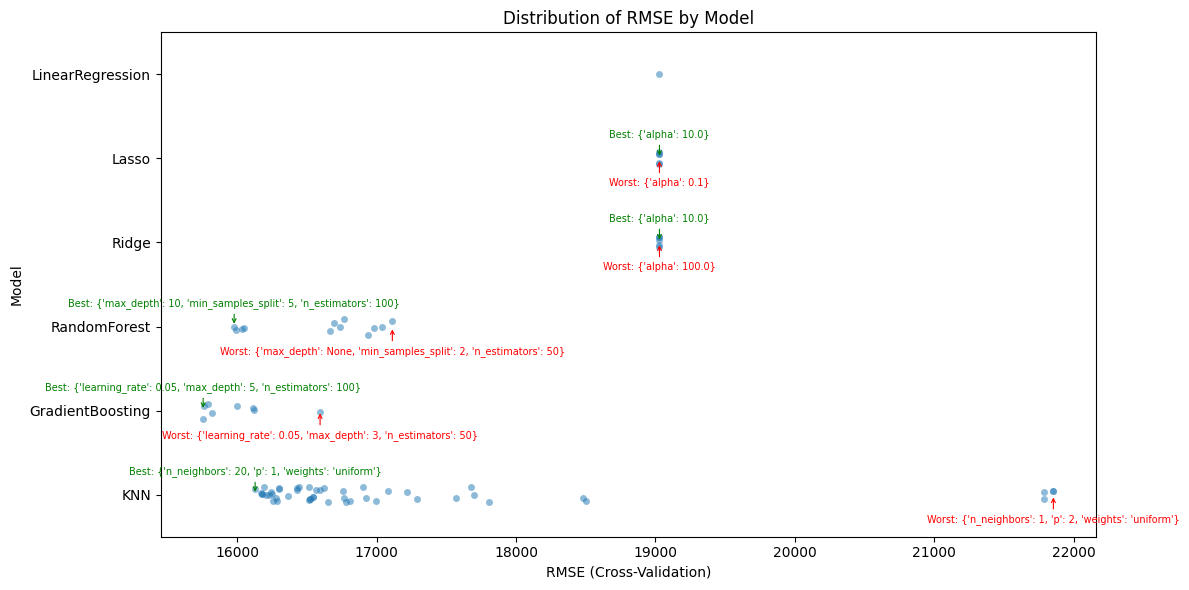

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,Model,param_alpha,param_max_depth,param_min_samples_split,param_n_estimators,param_learning_rate,param_n_neighbors,param_p,param_weights,rmse
0,0.006051,0.000003,0.002203,0.000401,{},-19261.383946,-19410.974027,-19130.680519,-18963.012975,-18377.693877,...,LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19028.749069
1,0.006969,0.000823,0.002900,0.000560,{'alpha': 0.001},-19261.384035,-19410.974114,-19130.680445,-18963.012933,-18377.693810,...,Lasso,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19028.749067
2,0.008376,0.001814,0.003428,0.000663,{'alpha': 0.01},-19261.384838,-19410.974900,-19130.679901,-18963.012557,-18377.693203,...,Lasso,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19028.749080
3,0.007966,0.000388,0.004035,0.000644,{'alpha': 0.1},-19261.392852,-19410.982749,-19130.673132,-18963.008914,-18377.689883,...,Lasso,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19028.749506
4,0.007679,0.000388,0.003746,0.000241,{'alpha': 1.0},-19261.473536,-19411.055456,-19130.605525,-18962.971330,-18377.629223,...,Lasso,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19028.747014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.036289,0.033033,0.171768,0.154857,"{'n_neighbors': 35, 'p': 2, 'weights': 'distan...",-17177.822594,-16462.583078,-16629.902597,-16338.197400,-16024.014800,...,KNN,NaN,NaN,NaN,NaN,NaN,35.0,2.0,distance,16526.504094
75,0.020492,0.004447,0.133878,0.021939,"{'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}",-17187.530611,-16505.440390,-16385.706553,-16051.214981,-15376.235721,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,uniform,16301.225651
76,0.046222,0.050099,0.121379,0.017327,"{'n_neighbors': 40, 'p': 1, 'weights': 'distan...",-17239.233087,-16506.578359,-16583.442626,-16279.999053,-15969.746620,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,distance,16515.799949
77,0.018979,0.001042,0.092489,0.005923,"{'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}",-17266.442786,-16618.831626,-16475.705885,-16200.706470,-15587.821066,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,2.0,uniform,16429.901567


In [75]:
from functions.plotter import plot_cv_metric_distribution
plot_cv_metric_distribution([all_grid], metric_name="rmse", maximize=False)

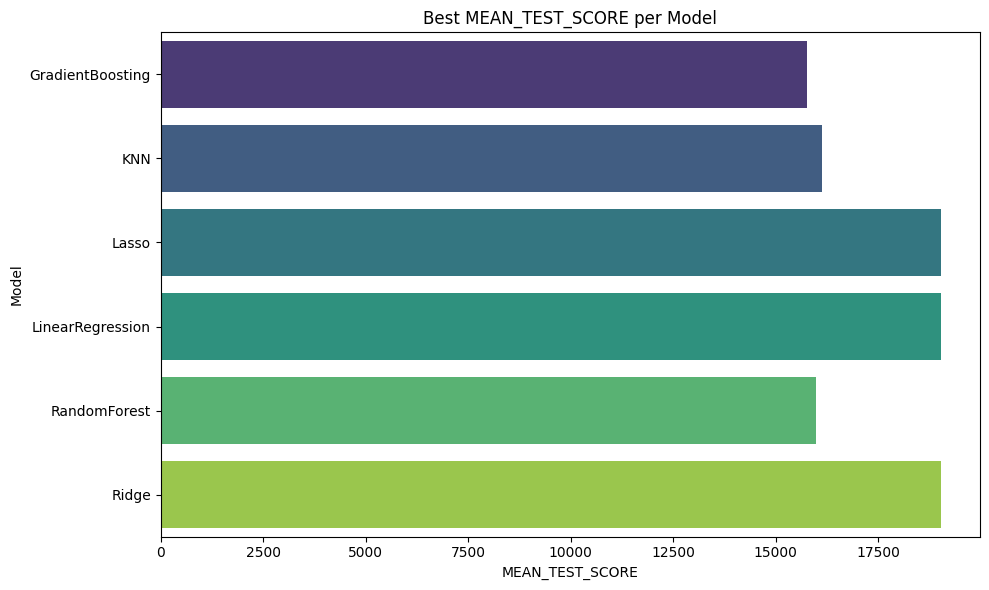

In [76]:
from functions.plotter import plot_best_metric_per_model
best_rmse_df = plot_best_metric_per_model([all_grid], metric='mean_test_score', maximize=False)

In [77]:
from functions.model_transformer import CustomPreprocessor
preprocessor = CustomPreprocessor(encoder, scaler, features_ols_dict)

In [78]:
from functions.save_models import save_pipeline_models
save_path = "./results/reg1"
save_pipeline_models(preprocessor, best_models,save_path)

Guardado pipeline: ./results/reg1\LinearRegression_pipeline.joblib
Guardado pipeline: ./results/reg1\Lasso_pipeline.joblib
Guardado pipeline: ./results/reg1\Ridge_pipeline.joblib
Guardado pipeline: ./results/reg1\RandomForest_pipeline.joblib
Guardado pipeline: ./results/reg1\GradientBoosting_pipeline.joblib
Guardado pipeline: ./results/reg1\KNN_pipeline.joblib


In [ ]:
#Cargar el dataset de nuevo - Solo para probar el comportamiento del modelo graficamente
from sklearn.model_selection import train_test_split
from functions.data_loader import load_excel_data
file = "../../data/BASE DE DATOS PCC_cleaned.xlsx"
df_char = load_excel_data(file)

X = df_char[features_ols]
y = df_char['fabricadas'] 
X_train_original = X.loc[X_train_selected.index]
X_test_original = X.loc[X_test_selected.index]
y_train_original = y.loc[X_train_selected.index]
y_test_original = y.loc[X_test_selected.index] #Asegurando el mismo seed para que la division sea igual

Archivo cargado correctamente desde ../../data/BASE DE DATOS PCC_cleaned.xlsx


In [80]:
#Comportamiento del mejor modelo (menor RMSE) - o el modelo que se quiere ver
from joblib import load
model_name = "GradientBoosting"
# Ruta al archivo
pipeline_path = os.path.join("results", "reg1", f"{model_name}_pipeline.joblib")

# Cargar el pipeline completo (encoder + scaler + modelo)
pipeline = load(pipeline_path)

y_train_pred = pipeline.predict(X_train_original)
y_test_pred = pipeline.predict(X_test_original)


C:\Users\yosse\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\yosse\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [81]:
#Solo para comprobar funcionamiento correcto del model transformer
import pandas as pd

# Obtener columnas categóricas y numéricas
cat_cols = [col for col, t in features_ols_dict.items() if t == 'categorical']
num_cols = [col for col, t in features_ols_dict.items() if t == 'numeric']

# Transformar con el preprocessor (numpy array)
X_transformed = pipeline.named_steps['preprocessor'].transform(X_train_original)


# Convertir a DataFrame con esos nombres
df_transformed = pd.DataFrame(X_transformed, columns=features_ols, index=X_train_original.index)

print(df_transformed.head())
print("-"*50)
print(X_train_selected.head())


       seccion  proceso  usuario  duracion_min  hora_inicio
15975      1.0     16.0     13.0     -0.902132    -1.565253
16358      0.0     16.0      9.0     -0.142936    -0.005722
4467       0.0     10.0     23.0      2.334324     1.085949
16999      2.0     16.0     28.0      0.680706    -0.941441
9688       1.0     16.0     26.0     -0.516388    -0.785488
--------------------------------------------------
       seccion  proceso  usuario  duracion_min  hora_inicio
15975      1.0     16.0     13.0     -0.902132    -1.565253
16358      0.0     16.0      9.0     -0.142936    -0.005722
4467       0.0     10.0     23.0      2.334324     1.085949
16999      2.0     16.0     28.0      0.680706    -0.941441
9688       1.0     16.0     26.0     -0.516388    -0.785488


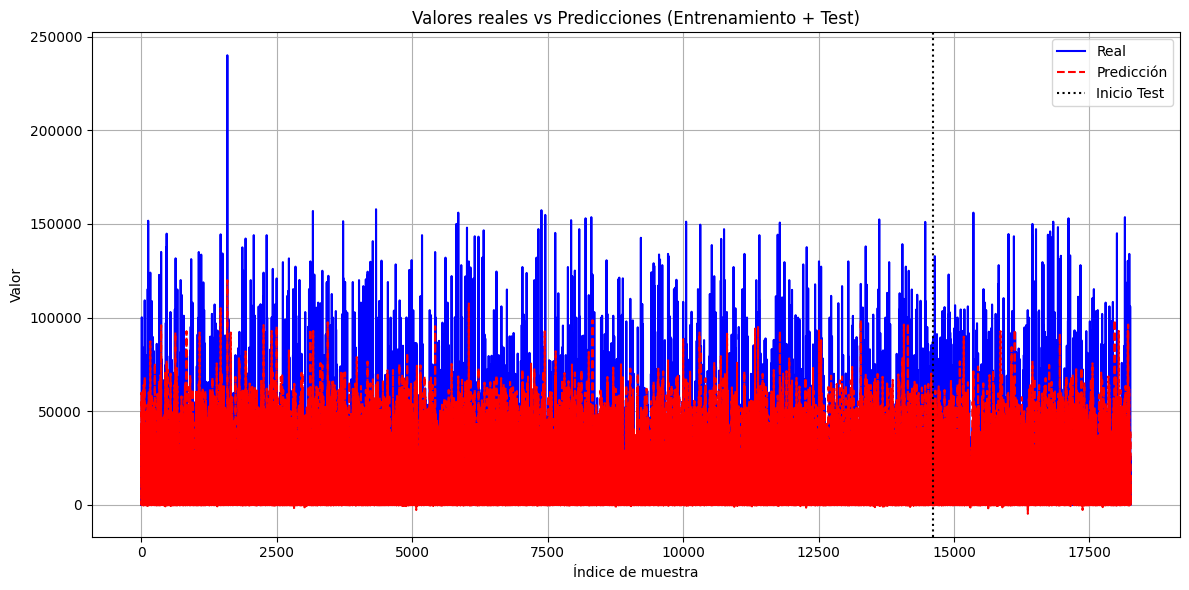

In [82]:
from functions.plotter import plot_dataprediction


plot_dataprediction(y_train=y_train_selected,y_test=y_test_selected,y_pred_test=y_test_pred,y_pred_train=y_train_pred)

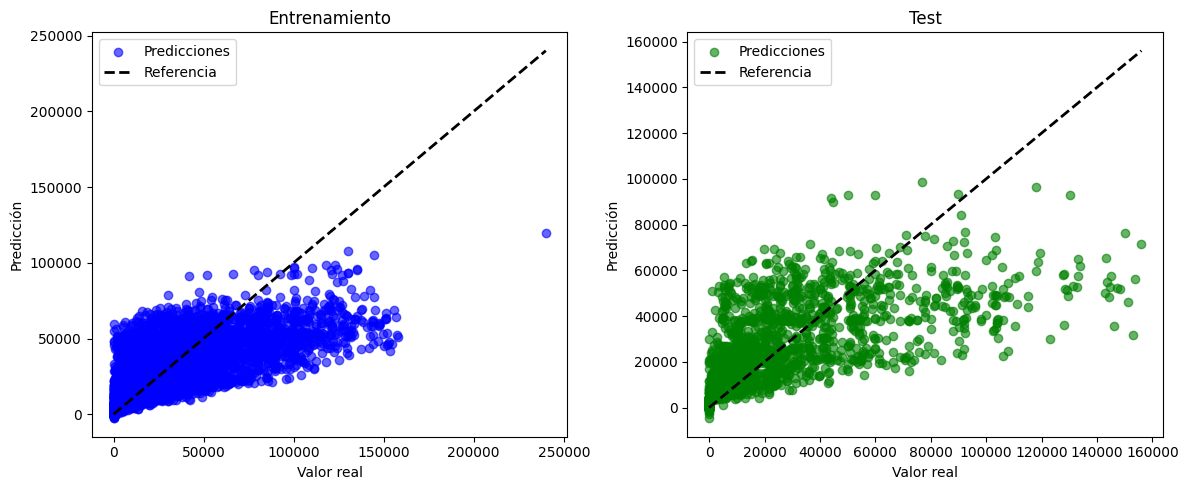

In [83]:
from functions.plotter import plot_dataprediction, plot_dataprediction_comparison


plot_dataprediction_comparison(y_train=y_train_selected,y_test=y_test_selected,y_pred_test=y_test_pred,y_pred_train=y_train_pred)

In [84]:

#Pueden existir componentes temporales que estén influyendo (primer semestre tenga mas produccion por x razon, etc) - Mas bien como conclusion de porque el modelo puede no estar ajustando tan bien
#Verificar si estas variables tienen impacto sobre las fabricadas - """"
#Agregar una variable auxiliar que ayude a escalar la predicción (antes de 01-2024 o despues de 01-2024) - Verificar si vale la pena para nuestra aplicacion


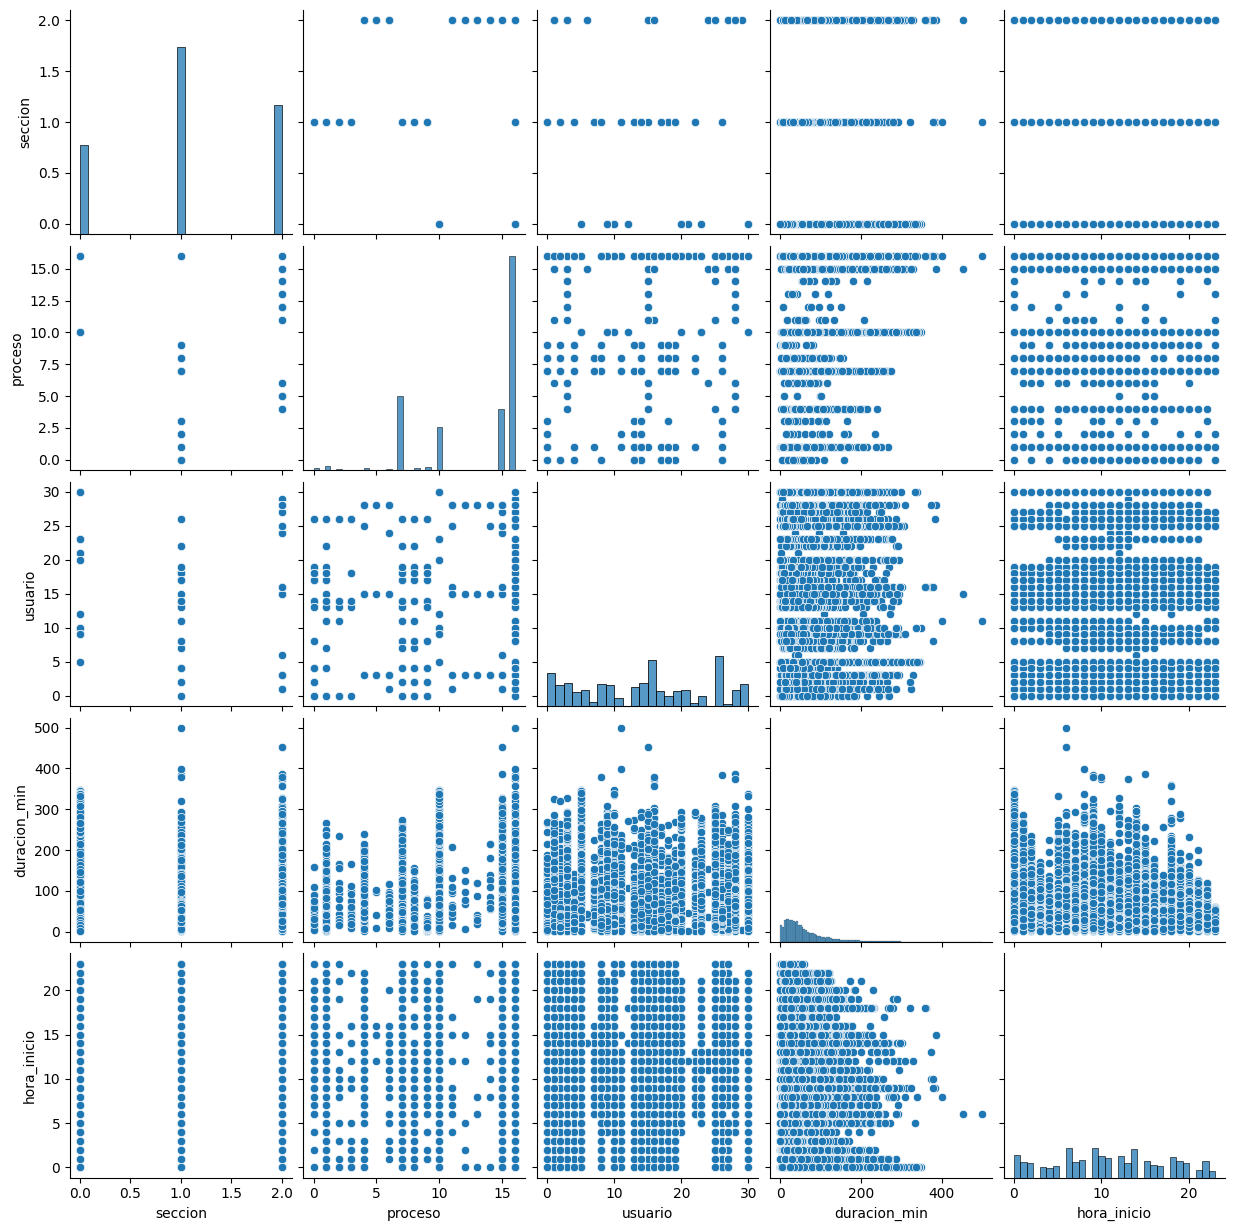

In [85]:
#Grafico entre predictores y variable a predecir

import seaborn as sns
import pandas as pd

# Copia del df para evitar modificar el original
df_plot = df_char.copy()

# Codificar variables categóricas
for col in features_ols:
    #Si es categorica en las features entonces asignarle un numero
        if features.get(col) == 'categorical':
                df_plot[col] = df_plot[col].astype('category').cat.codes

sns.pairplot(df_plot[features_ols])


In [86]:
#Para analizar la multicolinealidad e incluir las variables categoricas se utiliza el modelo (preprocesor sin predictor para codificar las variables a numeros y poder observarlos en la matriz de correlacion)

# Transformar con el preprocessor (numpy array)
X_transformed = pipeline.named_steps['preprocessor'].transform(X)


# Convertir a DataFrame con esos nombres
df_transformed = pd.DataFrame(X_transformed, columns=features_ols, index=X.index)
df_transformed


,seccion,proceso,usuario,duracion_min,hora_inicio
0,1.0,1.0,26.0,0.033080,-0.317628
1,1.0,1.0,26.0,1.767907,-0.161675
2,1.0,1.0,26.0,-0.250967,0.618090
3,1.0,1.0,13.0,2.608499,1.553808
4,1.0,1.0,13.0,0.006072,-1.721206
...,...,...,...,...,...
18256,1.0,16.0,4.0,-0.998056,1.865715
18257,1.0,16.0,4.0,-0.661857,1.865715
18258,1.0,16.0,4.0,-0.690727,-1.721206
18259,1.0,16.0,8.0,-0.131947,-0.161675


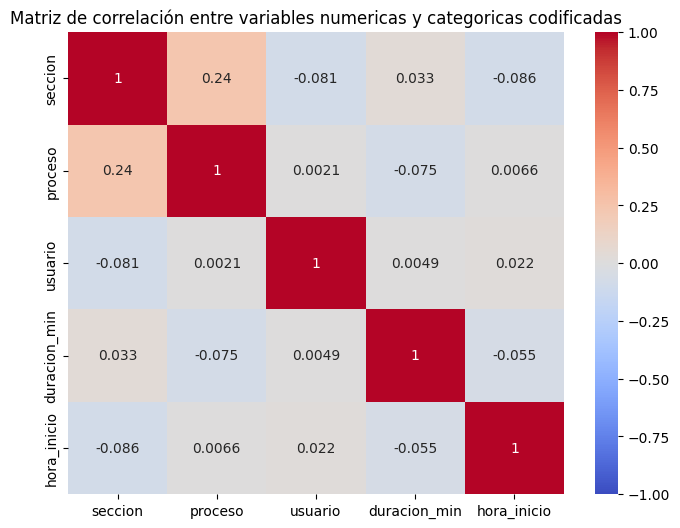

In [87]:
#Revisar la multicolinealidad de las variables
from matplotlib import pyplot as plt

from functions.plotter import corr_matrix_plot

corr_matrix_pearson = df_transformed.corr(method='pearson')
corr_matrix_plot(corr_matrix_pearson)

In [88]:
#VIF: Variance inflation factor - Consultado de internet: VIF mide cuánto aumenta la varianza de los coeficientes estimados debido a la colinealidad - segun el rango ideal es:
#VIF	Interpretación
#= 1	No hay multicolinealidad
#1 - 5	Aceptable, baja colinealidad
#5 - 10	Posible multicolinealidad.
#> 10	Alta multicolinealidad.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

X_numeric = df_transformed
X_with_const = add_constant(X_numeric)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                   for i in range(X_with_const.shape[1])]

print(vif_data)


       Variable        VIF
0         const  15.247037
1       seccion   1.080940
2       proceso   1.071281
3       usuario   1.007524
4  duracion_min   1.011201
5   hora_inicio   1.011031
